# **Student Names and IDs**
Edward Habelrih: 260985979 <br>
Xavier Celestin - 260986379

# **IMPORTED LIBRARIES**

In [2]:
import cv2 as cv
import numpy as np
!pip install ultralytics
from ultralytics import YOLO
from ultralytics.solutions import object_counter
from ultralytics.solutions import speed_estimation
from collections import defaultdict
from time import time
from ultralytics.utils.checks import check_imshow
from ultralytics.utils.plotting import Annotator, colors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 13.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

# **PATH VARIABLE**

In [3]:
path = '/content/drive/My Drive/Colab Notebooks/Final Project/'

# **YOLOv8 speed_estimation.py (modified)**

In [4]:
class CustomSpeedEstimator:
    """A class to estimation speed of objects in real-time video stream based on their tracks."""

    def __init__(self):
        """Initializes the speed-estimator class with default values for Visual, Image, track and speed parameters."""

        # Visual & im0 information
        self.im0 = None
        self.annotator = None
        self.view_img = False

        # Region information
        self.reg_pts = [(20, 400), (1260, 400)]
        self.region_thickness = 3

        # Predict/track information
        self.clss = None
        self.names = None
        self.boxes = None
        self.trk_ids = None
        self.trk_pts = None
        self.line_thickness = 2
        self.trk_history = defaultdict(list)

        # Speed estimator information
        self.current_time = 0
        self.dist_data = {}
        self.trk_idslist = []
        self.spdl_dist_thresh = 10
        self.trk_previous_times = {}
        self.trk_previous_points = {}
        self.speeds_dict = {}
        self.passed_pedestrians = {}
        # Check if environment support imshow
        self.env_check = check_imshow(warn=True)

    def set_args(
        self,
        reg_pts,
        names,
        view_img=False,
        line_thickness=2,
        region_thickness=5,
        spdl_dist_thresh=10,
    ):
        """
        Configures the speed estimation and display parameters.

        Args:
            reg_pts (list): Initial list of points defining the speed calculation region.
            names (dict): object detection classes names
            view_img (bool): Flag indicating frame display
            line_thickness (int): Line thickness for bounding boxes.
            region_thickness (int): Speed estimation region thickness
            spdl_dist_thresh (int): Euclidean distance threshold for speed line
        """
        if reg_pts is None:
            print("Region points not provided, using default values")
        else:
            self.reg_pts = reg_pts
        self.names = names
        self.view_img = view_img
        self.line_thickness = line_thickness
        self.region_thickness = region_thickness
        self.spdl_dist_thresh = spdl_dist_thresh

    def extract_tracks(self, tracks):
        """
        Extracts results from the provided data.

        Args:
            tracks (list): List of tracks obtained from the object tracking process.
        """
        self.boxes = tracks[0].boxes.xyxy.cpu()
        self.clss = tracks[0].boxes.cls.cpu().tolist()
        self.trk_ids = tracks[0].boxes.id.int().cpu().tolist()

    def store_track_info(self, track_id, box):
        """
        Store track data.

        Args:
            track_id (int): object track id.
            box (list): object bounding box data
        """
        track = self.trk_history[track_id]
        bbox_center = (float((box[0] + box[2]) / 2), float((box[1] + box[3]) / 2))
        track.append(bbox_center)

        if len(track) > 30:
            track.pop(0)

        self.trk_pts = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
        return track

    def plot_box_and_track(self, track_id, box, cls, track):
        """
        Plot track and bounding box.

        Args:
            track_id (int): object track id.
            box (list): object bounding box data
            cls (str): object class name
            track (list): tracking history for tracks path drawing
        """
        speed_label = f"{int(self.dist_data[track_id])}km/ph" if track_id in self.dist_data else self.names[int(cls)]
        bbox_color = colors(int(track_id)) if track_id in self.dist_data else (255, 0, 255)

        self.annotator.box_label(box, speed_label, bbox_color)

        cv.polylines(self.im0, [self.trk_pts], isClosed=False, color=(0, 255, 0), thickness=1)
        cv.circle(self.im0, (int(track[-1][0]), int(track[-1][1])), 5, bbox_color, -1)

    def calculate_speed(self, trk_id, track):
        """
        Calculation of object speed.

        Args:
            trk_id (int): object track id.
            track (list): tracking history for tracks path drawing
        """

        if not self.reg_pts[0][0] < track[-1][0] < self.reg_pts[1][0]:
            return
        if self.reg_pts[1][1] - self.spdl_dist_thresh < track[-1][1] < self.reg_pts[1][1] + self.spdl_dist_thresh:
            direction = "known"

        elif self.reg_pts[0][1] - self.spdl_dist_thresh < track[-1][1] < self.reg_pts[0][1] + self.spdl_dist_thresh:
            direction = "known"

        else:
            direction = "unknown"

        if self.trk_previous_times[trk_id] != 0 and direction != "unknown" and trk_id not in self.trk_idslist:
            self.trk_idslist.append(trk_id)

            time_difference = time() - self.trk_previous_times[trk_id]
            if time_difference > 0:
                dist_difference = np.abs(track[-1][1] - self.trk_previous_points[trk_id][1])
                speed = dist_difference / time_difference
                self.dist_data[trk_id] = speed

        self.trk_previous_times[trk_id] = time()
        self.trk_previous_points[trk_id] = track[-1]

    def estimate_speed(self, im0, tracks, region_color=(255, 0, 0)):
        """
        Calculate object based on tracking data.

        Args:
            im0 (nd array): Image
            tracks (list): List of tracks obtained from the object tracking process.
            region_color (tuple): Color to use when drawing regions.
        """
        self.im0 = im0
        if tracks[0].boxes.id is None:
            if self.view_img and self.env_check:
                self.display_frames()
            return im0
        self.extract_tracks(tracks)

        self.annotator = Annotator(self.im0, line_width=2)
        self.annotator.draw_region(reg_pts=self.reg_pts, color=region_color, thickness=self.region_thickness)

        for box, trk_id, cls in zip(self.boxes, self.trk_ids, self.clss):
            track = self.store_track_info(trk_id, box)

            if trk_id not in self.trk_previous_times:
                self.trk_previous_times[trk_id] = 0

            self.plot_box_and_track(trk_id, box, cls, track)
            self.calculate_speed(trk_id, track)
            speed_label = int(self.dist_data[trk_id]) if trk_id in self.dist_data else None
            if not(speed_label is None):
              if cls == 2:
                self.speeds_dict[trk_id] = speed_label
              elif cls == 0:
                self.passed_pedestrians[trk_id] = 1
        if self.view_img and self.env_check:
            self.display_frames()

        return im0

    def display_frames(self):
        """Display frame."""
        cv.imshow("Ultralytics Speed Estimation", self.im0)
        if cv.waitKey(1) & 0xFF == ord("q"):
            return


if __name__ == "__main__":
    CustomSpeedEstimator()

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()



In [13]:
# Video paths
st_cath_vid_path = path + 'st-catherines_drive.mp4'
mcgill_drive_vid_path = path + 'mcgill_drive.mp4'

def analyze_video(video_path):
    # Load Yolov8 model
    model = YOLO("yolov8x.pt")
    cap = cv.VideoCapture(video_path)
    assert cap.isOpened(), "Error reading video file"
    w, h, fps = (int(cap.get(x)) for x in (cv.CAP_PROP_FRAME_WIDTH, cv.CAP_PROP_FRAME_HEIGHT, cv.CAP_PROP_FPS))

    # Define region points
    region_points_speed_object = [(0, 3*h/4), (w, 3*h/4)]
    region_points_object_counter_left = [(0, h/2), (w/7, h/2), (w/7, h), (0, h)]
    region_points_object_counter_right = [(6*w/7, h/2), (w, h/2), (w, h), (6*w/7, h)]

    # Video writer
    output_video_path = video_path.replace('.mp4', '_output.mp4')
    video_writer = cv.VideoWriter(output_video_path,
                                  cv.VideoWriter_fourcc(*'mp4v'),
                                  fps,
                                  (w, h))

    # Initialize object counters and speed estimator
    counter_left = object_counter.ObjectCounter()
    counter_left.set_args(view_img=True,
                          reg_pts=region_points_object_counter_left,
                          classes_names=model.names,
                          draw_tracks=False,
                          line_dist_thresh=h/2,
                          line_thickness=10)

    counter_right = object_counter.ObjectCounter()
    counter_right.set_args(view_img=True,
                           reg_pts=region_points_object_counter_right,
                           classes_names=model.names,
                           draw_tracks=True,
                           line_dist_thresh=h/2,
                           line_thickness=10)

    speed_obj = CustomSpeedEstimator()
    speed_obj.set_args(reg_pts=region_points_speed_object,
                       names=model.names,
                       line_thickness=50,
                       region_thickness=50,
                       view_img=True)

    # Process each frame and write to the output video file
    # Count cars
    while cap.isOpened():
        success, im0 = cap.read()
        if not success:
            break
        tracks = model.track(im0, persist=True, show=False, tracker='bytetrack.yaml', classes=2, verbose=False)
        im0 = speed_obj.estimate_speed(im0, tracks)
        video_writer.write(im0)
    cap.release()

    # Count pedestrians
    cap = cv.VideoCapture(video_path)
    assert cap.isOpened(), "Error reading video file"
    while cap.isOpened():
        success, im0 = cap.read()
        if not success:
            break
        tracks = model.track(im0, persist=True, classes=0, verbose=False)
        im0 = counter_left.start_counting(im0, tracks)
        im0 = counter_right.start_counting(im0, tracks)
        video_writer.write(im0)

    #Release resources
    cap.release()
    video_writer.release ()

    # Filter out extreme outliers
    speed_values = np.array(list(speed_obj.speeds_dict.values()))
    threshold = 300
    if np.any(speed_values > threshold):
        under_threshold = speed_values[speed_values < threshold]
        if len(under_threshold) > 1:
            sorted_under_threshold = np.sort(under_threshold)
            second_highest_value = sorted_under_threshold[-1]
        elif len(under_threshold) == 1:
            second_highest_value = under_threshold[0]
        else:
            second_highest_value = threshold
        final_speeds = np.where(speed_values > threshold, second_highest_value, speed_values)
    else:
        # If no values exceed the threshold, use the array as is
        final_speeds = speed_values.copy()

    variance = np.var(final_speeds)
    if variance > 1300:
         n_clusters = 3
    else:
         n_clusters = 2
    # K-means clustering
    kmeans = KMeans(n_clusters, n_init=100, random_state=42)
    kmeans.fit(final_speeds.reshape(-1, 1))
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_.flatten()
    centroids_sorted_indices = np.argsort(centroids)
    # Count parked and moving cars
    parked_cars = np.sum(labels == centroids_sorted_indices[1])
    moving_cars = np.sum(labels == centroids_sorted_indices[0])
    if(n_clusters == 3):
      opposite_moving_cars = np.sum(labels == centroids_sorted_indices[2])
      print("Number of  moving cars passed:", moving_cars+opposite_moving_cars)
    else:
      print("Number of moving cars passed:", moving_cars)
    print("Number of parked cars passed:", parked_cars)
    print("Number of pedestrians passed: " + str(counter_right.out_counts + counter_left.out_counts))
    print('\n')

#Run the method
print("St-Catherine Video Analysis")
analyze_video(st_cath_vid_path)
print("McGill Drive Video Analysis")
analyze_video(mcgill_drive_vid_path)

St-Catherine Video Analysis
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Polygon Counter Initiated.
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Polygon Counter Initiated.
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Number of moving cars passed: 29
Number of parked cars passed: 25
Number of pedestrians passed: 40


McGill Drive Video Analysis
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Polygon Counter Initiated.
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Polygon Counter Initiated.
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Number of  moving cars passed: 20
Number of parked cars passed: 11
Number of pedestrians passed: 16




# **Final Report**

All images referenced in this text cell can be observed in the code cell below.

**Approach Taken**<br>
This code analyzes dashcam footage to determine the number of parked cars, moving cars, and pedestrians passed by the user. It utilizes the YOLOv8 model for object detection, tracking, and speed estimation. The decision to use YOLOv8 was based on our extensive experience with the model in previous assignments and its consistent performance, especially in real life scenarios such as this one.

The model demonstrates high accuracy in detecting cars, with few exceptions, and successfully identifies most pedestrians. However, some pedestrians may be hidden by cars in certain frames, leading to occasional missed detections. Nevertheless, when the sidewalk is clearly visible, pedestrians are reliably identified by the model.

In addition to object detection, YOLOv8 features an object counter module and a speed estimation module. These modules enable the model to not only detect objects but also to track them over time. By calculating the variation in the tracker's distance over time, the model can estimate the speed of each detected object.

ASSUMPTIONS:
The following assumptions were made. When counting vehicles, we only took into account objects labeled as "Car" from the model and not "Truck" nor "Bus". The assignment instructions specifically referenced "cars" and not all vehicles. The assignment also clearly states "parked cars passed", "moving cars passed", and "pedestrians passed". When producing our results, we are counting the entities that pass and not everything present on the screen.

The process begins with the selection and integration of the YOLOv8 model, specifically chosen for its comprehensive training and accurate results. For this program, we opted for the "x" version, prioritizing accuracy and depth of results over processing speed. The decision was made based on the final project requirements, which did not specify execution time as an evaluation criterion. Thus, to ensure the most reliable detections were made, we opted for a better pre-trained version of the model. The difference in performance and runtime of the models can be better seen in the image below (check cell below).

To accurately track and calculate the speeds of passing cars, a "speed_estimation" object is created. This object utilizes a bytetrack tracking algorithm which is notably reliable in real life scenarios such as this one to track each car's position across successive video frames. The speed of each car is determined when its tracker intersects a predefined speed estimation region defined in the object. This region, depicted as a blue line in the image below, is strategically placed to align with the car's trajectory just as it passes the user who is driving. Each car is assigned a unique identifier, ensuring that the speed calculation is persistent and retains accuracy across different frames. The tracker for each car, represented by a dot and activates when it intersects the speed region defined. In this process, we are ensuring through the model's parameters that only cars are detected and get a speed assigned to them.

To effectively analyze the speeds of detected cars and classify them as either moving or parked, it is crucial to accurately capture and store this data. In our program, this is achieved by modifying the "speed_estimation." module from the YOLOv8's "ultralytics/solutions" directory. A key enhancement was the introduction of a new class attribute, "speeds_dict". This dictionary is designed to store the speeds of each detected car, ensuring that each vehicle's speed is recorded only once. This modification allows for precise speed tracking and facilitates the analysis that is to be performed in the later steps.

After gathering all speed data, it became clear that the speeds could be categorized into distinct clusters. Cars moving in the same direction as the user generally displayed slower speeds, while parked cars showed moderately higher speeds. On the other hand, cars moving in the opposite direction as the user displayed the highest recorded speeds. By clustering these speeds, it became feasible to differentiate between parked and moving cars.

Rather than manually setting speed thresholds for each video, a more flexible approach was adopted using K-means clustering. This method automatically segments the data into two or three distinct clusters, providing a generalized solution suitable for any dashcam footage. The number of clusters is dynamically determined based on the variance of the recorded speeds. A higher variance indicates a broad range of speeds, prompting the use of three clusters. Conversely, when the variance is below a certain threshold, indicating more uniform speed data (typically when no cars are moving in the opposite direction), two clusters are used. This adaptive clustering approach ensures a more versatile approach to different possible traffic scenarios. After the speed data was assigned to every cluster, an addition is performed to count the number of moving cars passed and parked cars passed.

To count the number of pedestrians passed, the object counter module was utilized. An object counter object was created with specific region points defined. The model was configured to only count objects classified as "Person". The regions were strategically delimited to detect and count all pedestrians passed, as shown in the image below. However, this approach does not account for pedestrians in the middle of the street. Extending the coverage of the regions to cover the middle of the street would result in also counting pedestrians further away on the sidewalk or on the street that have not yet been passed due to the perspective of the dashcam. After completing the video analysis, the counts from both regions are added to determine the total number of pedestrians passed.   <br>

**Software Used**<br>


In this project, we utilized a variety of software tools to analyze the given footage. OpenCV was used for handling video files, such as opening, reading, and displaying them. NumPy helped perform numerical analysis, especially useful for processing the speeds we collected. We chose the "x" version of the Ultralytics YOLOv8 model for its ability to accurately detect objects in each frame. We also used additional Ultralytics tools such as the object counter and the speed estimator to count pedestrians and calculate the speeds of vehicles as they move through the frames. The Time module helped me measure how long each model took to run, which was important for comparing their performance. For visual enhancements, We used Ultralytics's Annotator and Colors packages to add annotations and color-coded metrics to the video. Finally, we used the K-means algorithm from scikit-learn to organize the speed data into clusters. This comprehensive set of tools made the program shine.

<br>


**Results**<br>
St-Catherine drive:<br>

Results manually obtained:<br>
Moving cars passed: 1<br>
Parked cars passed: 54 <br>
Pedestrians passed: 78<br>
<br>
Results obtained from program:<br>
Moving cars passed: 29<br>
Parked cars passed: 25 <br>
Pedestrians passed: 40<br>
<br>
Accuracy:<br>
Moving cars that were misidentified/not identified: 28<br>
Parked cars that were misidentified/not identified: 29<br>
Pedestrians that were misidentified/not identified: 38<br>
<br>

McGill Drive:<br>

Results manually obtained:<br>
Moving cars passed: 22 <br>
Parked cars passed: 16 <br>
Pedestrians passed: 26<br>
<br>
Results obtained from program:<br>
Moving cars passed: 20<br>
Parked cars passed: 11 <br>
Pedestrians passed: 16<br>
<br>
Accuracy:<br>
Moving cars that were misidentified/not identified: 2<br>
Parked cars that were misidentified/not identified: 5<br>
Pedestrians that were misidentified/not identified: 10<br>
<br>

**Performance and Problems**<br>
The program demonstrated its highest level of accuracy in scenarios with a diverse array of vehicle speeds, such as in the McGill Drive video where it successfully identified various moving and parked car + pedestrians. However, it faced challenged in the St-Catherine Drive video, where there was only one moving car amongst many parked ones. This lack of diversity in speeds made it difficult for the program to accurately cluster and categorize the vehicles, leading to some misidentification between moving and parked cars which will be elaborated further in the next paragraphs.

Regarding runtime, the program completed its analysis of both videos in 9 minutes when using the more sophisticated 'x' model. In contrast, employing the 'n' model, which is less trained and precise, reduced the runtime to just a third of that duration. While the 'x' model provided more consistent results across different runs, the tracking inconsistencies still posed significant challenges, affecting the reliability of the speed measurements.

The program faces several challenges primarily due to the tracking being entirely left in the hands of the YOLOv8 model. While the theory that cars moving in the same direction show slower speeds, parked cars display intermediate speeds, and cars moving in the opposite direction register the highest speeds is sound, practical issues arise with the tracker's inconsistency accross several vehicles. The movement of the tracker across different cars and frames can lead to less accurate categorizations of speed ranges.

Moreover, the use of K-means has complexities of its own. For instance, the presence of outlier speed values can significanlty skew the clustering results, potentially misrepresenting the true distribution of vehicle speeds. Furthermore, the scenario where a single moving car is among approximately fifty parked ones, poses a particular challenge. K-means clustering tends to average out such situations, making it difficult to accurately isolate and identify individual variances in speed especially when speeds aren't as consistent between parked cars. The range of speeds is higher more cars get associated across the clusters.

In both videos, the program occasionally missed detecting some pedestrians. This typically occurred when pedestrians were hidden by vehicles at the moments they crossed the predefined counter regions, or when individuals were part of a crowd, making it challenging for the model to distinguish each person distinctly.


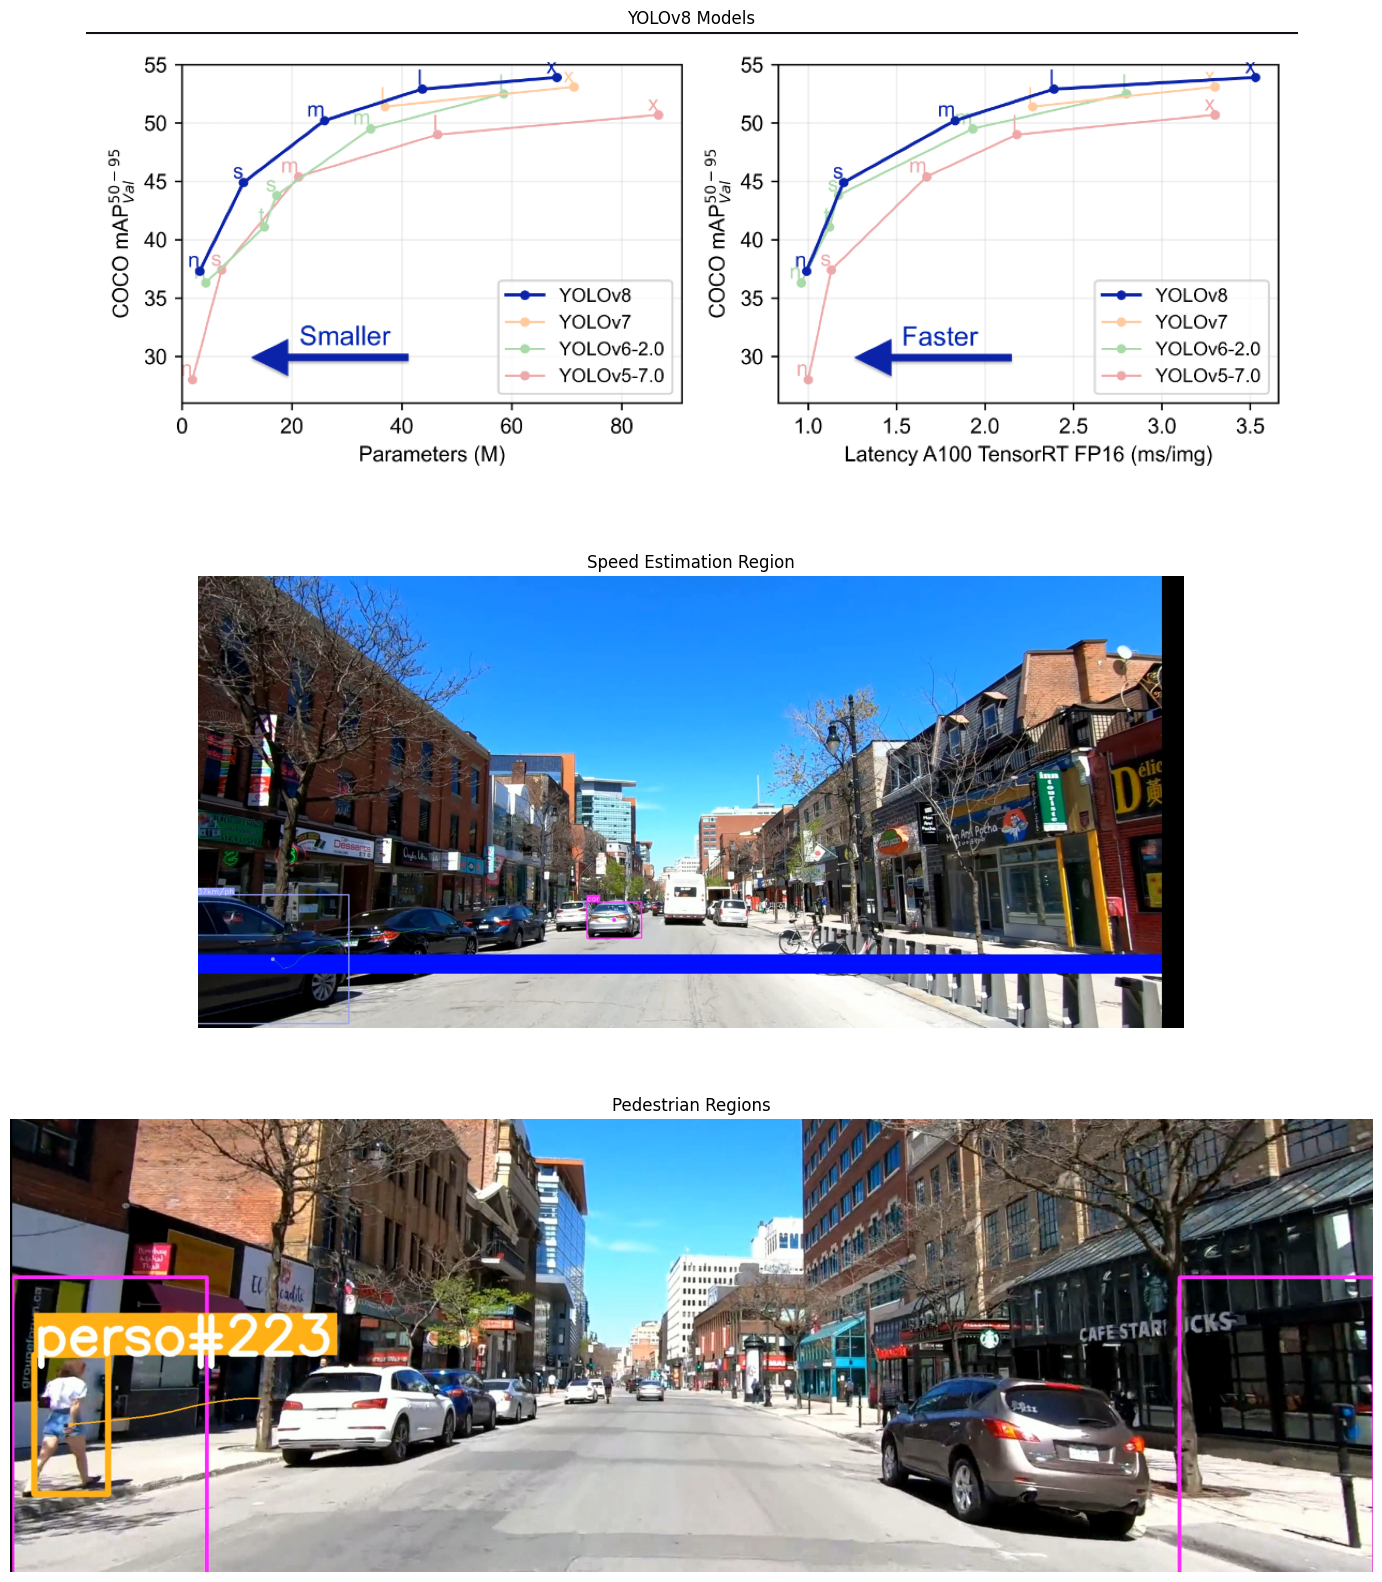

In [10]:
#Image paths
yolomodelimage = path+'yolov8models.png'
speed = path+'speedregion.png'
people = path+'peopleregion.png'

# Load images
yolo_img = mpimg.imread(yolomodelimage)
speed_img = mpimg.imread(speed)
people_img = mpimg.imread(people)

# Set up the plot with subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 20))

# Display YOLO model image
axs[0].imshow(yolo_img)
axs[0].set_title('YOLOv8 Models')
axs[0].axis('off')

# Display Speed Estimation Region image
axs[1].imshow(speed_img)
axs[1].set_title('Speed Estimation Region')
axs[1].axis('off')

# Display Pedestrian Region image
axs[2].imshow(people_img)
axs[2].set_title('Pedestrian Regions')
axs[2].axis('off')

plt.show()